### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial import distance
from tqdm import tqdm

import spektral
import matplotlib.pyplot as plt

from spektral.layers.convolutional import GraphSageConv, GCNConv, EdgeConv, ECCConv
from spektral.layers.pooling import GlobalAttentionPool
from spektral import utils

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Flatten, Concatenate, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.optimizers import Adam

### Load prepared data

In [18]:
source = '/media/storage_3/abiricz/Mobilcell/TimeIntervalGraphs_spektral/'
#source = '/media/Data_storage/Mobilcell/TimeIntervalGraphs_spektral/'
source_pol = '/media/storage_3/abiricz/Mobilcell/DayPolygonData/'
files = np.array( sorted([ i for i in os.listdir(source) if 'line' in i ]) )
files = np.array( sorted([ j for j in files if '-3_' in j ]) )
files[:10], files.shape

(array(['graphNN_linegraph_samples_series-3_target-1_20181201.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181202.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181203.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181204.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181205.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181206.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181207.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181208.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181209.npz',
        'graphNN_linegraph_samples_series-3_target-1_20181210.npz'],
       dtype='<U56'), (151,))

In [19]:
dates = np.unique( [ j.split('_')[5][:-4] for j in files ] )
dates[:5]

array(['20181201', '20181202', '20181203', '20181204', '20181205'],
      dtype='<U8')

### Concept:
- node prediction on line graph -> edge weight prediction on the real graph
- spektral is a lightweight package to try a basic model out
- here presented: node prediction with minimal features (time, day coded) and 3 previous consequtive steps of edge weights are included to predict the edge weights for an hour in advance (t+1)

### Data loader 

In [16]:
def load_data(daynum, week=False):
    if not week:
        loaded = np.load( source+'graphNN_linegraph_samples_series-3_target-1_'+dates[daynum]+'.npz' )

        # load relevant data
        nfs_line = loaded['nf_line'] # time and day added as node features
        nf_line_targets = np.copy( nfs_line[:,:,3] )
        nfs_line = nfs_line[:,:, np.concatenate( ( np.arange(0,3), 
                                     np.arange(4,7), 
                                     np.arange(8, nfs_line.shape[2]) ) ) ]
        
        # normalization
        nfs_line[:,:,[0,1,2]] /= 1000
        nf_line_targets /= 1000

        # read and transform adj mat for use with graph NN
        adj_mat_line = loaded['adj_mat_line']
        adj_mat_line = utils.normalized_laplacian(adj_mat_line) # gen norm lapl
        adj_mat_line = np.repeat( np.expand_dims(adj_mat_line, 0), 20, 0 )    
        return adj_mat_line, nfs_line, nf_line_targets
    else:
        adj_mat_line_all = []
        nfs_line_all = []
        nf_line_targets_all = []
        for n in range( daynum, daynum+7 ):
            loaded = np.load( source+'graphNN_linegraph_samples_series-3_target-1_'+dates[daynum]+'.npz' )

            # load relevant data
            nfs_line = loaded['nf_line'] # time and day added as node features
            nf_line_targets = np.copy( nfs_line[:,:,3] )
            nfs_line = nfs_line[:,:, np.concatenate( ( np.arange(0,3), 
                                     np.arange(4,7), 
                                     np.arange(8, nfs_line.shape[2]) ) ) ]

            # normalization
            nfs_line[:,:,[0,1,2]] /= 1000
            nf_line_targets /= 1000

            # read and transform adj mat for use with graph NN
            adj_mat_line = loaded['adj_mat_line']
            adj_mat_line = utils.normalized_laplacian(adj_mat_line) # gen norm lapl
            adj_mat_line = np.repeat( np.expand_dims(adj_mat_line, 0), 20, 0 )
            
            adj_mat_line_all.append( adj_mat_line )
            nfs_line_all.append( nfs_line )
            nf_line_targets_all.append( nf_line_targets )
        adj_mat_line_all = np.concatenate( adj_mat_line_all )
        nfs_line_all = np.concatenate( nfs_line_all )
        nf_line_targets_all = np.concatenate( nf_line_targets_all )
        
        return adj_mat_line_all, nfs_line_all, nf_line_targets_all

#### Load a day

In [5]:
adj_mat, nfs, nf_targets = load_data(0)
adj_mat.shape, nfs.shape, nf_targets.shape

(20, 3150, 33)


((20, 3150, 3150), (20, 3150, 31), (20, 3150))

#### Load a week

### ML

#### Parameter settings

In [6]:
# Parameters
N = nfs.shape[-2]          # Number of nodes in the graphs
F = nfs.shape[-1]          # Node features dimensionality
#S = ef_mats.shape[-1]      # Edge feature dim
#N_line = nf_train_line.shape[-2]          # Number of nodes in the graphs
#F_line = nf_train_line.shape[-1]          # Node features dimensionality
# Dimensionalities of the targets
n_out = nf_targets.shape[-2]
learning_rate = 1e-3      # Learning rate for SGD
epochs = 20              # Number of training epochs
batch_size = 4         # Batch size
es_patience = 500           # Patience fot early stopping

#### Model definition

In [7]:
# Model definition
nf_in = Input(shape=(N, F))
adj_in = Input(shape=(N, N))

gc0 = GCNConv( 256, activation='relu')([nf_in, adj_in])
gc0 = GCNConv( 128, activation='relu')([gc0, adj_in])
gc0 = GCNConv( 128, activation='relu')([gc0, adj_in])
outp = GCNConv( 1, activation='relu')([gc0, adj_in])

In [8]:
# Build model
model = Model( inputs=[nf_in, adj_in], outputs=outp )
#model = multi_gpu_model(model, 2)
optimizer = Adam( lr=learning_rate, amsgrad=True, decay=1e-6 )
model.compile( optimizer=optimizer, loss='mae' )
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3150, 31)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3150, 3150)] 0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 3150, 256)    8192        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gcn_conv_1 (GCNConv)            (None, 3150, 128)    32896       gcn_conv[0][0]        

In [9]:
import gc # to free memory

#### Fitting the model

In [10]:
def fit_model(start_day=0, end_day=100, week=True):
    hists = []
    for n in np.arange(start_day, end_day, 7):
        adj_mat, nfs, nf_targets = load_data(n, week=week)
        history = model.fit([nfs, adj_mat],
                  nf_targets,
                  batch_size=batch_size,
                  validation_split=0.1,
                  epochs=epochs)
        hists.append(history)
        del adj_mat, nfs, nf_targets
        gc.collect()
    return hists

In [11]:
hists = fit_model(0, 100, True)

Epoch 1/20
32/32 [==============================] - 2s 73ms/step - loss: 0.0515 - val_loss: 0.0527
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0427 - val_loss: 0.0452
Epoch 3/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0377 - val_loss: 0.0394
Epoch 4/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0339 - val_loss: 0.0378
Epoch 5/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0329 - val_loss: 0.0356
Epoch 6/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0309 - val_loss: 0.0342
Epoch 7/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0299 - val_loss: 0.0334
Epoch 8/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0291 - val_loss: 0.0321
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0284 - val_loss: 0.0313
Epoch 10/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0286 - val_loss: 0.0321
Epoch 11/

32/32 [==============================] - 2s 57ms/step - loss: 0.0174 - val_loss: 0.0211
Epoch 4/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0176 - val_loss: 0.0218
Epoch 5/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0175 - val_loss: 0.0210
Epoch 6/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0178 - val_loss: 0.0214
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0178 - val_loss: 0.0214
Epoch 8/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0173 - val_loss: 0.0214
Epoch 9/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0172 - val_loss: 0.0208
Epoch 10/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0173 - val_loss: 0.0210
Epoch 11/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0174 - val_loss: 0.0211
Epoch 12/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0177 - val_loss: 0.0222
Epoch 13/20
32/32 

32/32 [==============================] - 2s 58ms/step - loss: 0.0157 - val_loss: 0.0183
Epoch 6/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0152 - val_loss: 0.0176
Epoch 7/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0151 - val_loss: 0.0177
Epoch 8/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0149 - val_loss: 0.0178
Epoch 9/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0151 - val_loss: 0.0195
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0153 - val_loss: 0.0179
Epoch 11/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0153 - val_loss: 0.0182
Epoch 12/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0158 - val_loss: 0.0186
Epoch 13/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0158 - val_loss: 0.0180
Epoch 14/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0150 - val_loss: 0.0175
Epoch 15/20
32/3

32/32 [==============================] - 2s 57ms/step - loss: 0.0158 - val_loss: 0.0180
Epoch 8/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0155 - val_loss: 0.0176
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 11/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0153 - val_loss: 0.0177
Epoch 12/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0150 - val_loss: 0.0178
Epoch 13/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0151 - val_loss: 0.0180
Epoch 14/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0155 - val_loss: 0.0181
Epoch 15/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0151 - val_loss: 0.0175
Epoch 16/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0150 - val_loss: 0.0174
Epoch 17/20
32

#### Loss at learning

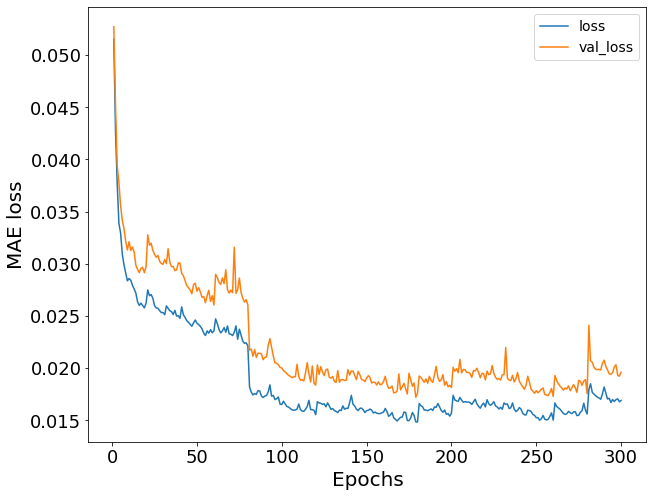

In [13]:
plt.figure( figsize=(10,8) )
plt.plot( np.arange(len(hists)*epochs)+1, np.concatenate( [ j.history['loss']  for j in hists ] ), label='loss' )
plt.plot( np.arange(len(hists)*epochs)+1, np.concatenate( [ j.history['val_loss']  for j in hists ] ), label='val_loss' )
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MAE loss', fontsize=20)
plt.tick_params(labelsize=18)
plt.legend( fontsize=14 )

### Evaluation

In [20]:
# Eval model
eval_losses = []
for n in tqdm( range(100, 150) ):
    adj_mat, nfs, nf_targets = load_data(n)
    eval_loss = model.evaluate([nfs, adj_mat],
              nf_targets,
              batch_size=batch_size, verbose=0 )
    eval_losses.append(eval_loss)


100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


Text(0, 0.5, 'Occurences')

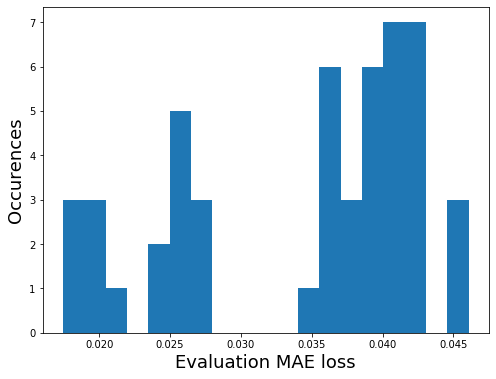

In [32]:
plt.figure( figsize=(8,6) )
_ = plt.hist( eval_losses, bins=np.linspace( min(eval_losses), max(eval_losses), 20 ) )
plt.xlabel( 'Evaluation MAE loss', fontsize=18 )
plt.ylabel( 'Occurences', fontsize=18)

### Prediction

#### Load info of graph conversion

In [79]:
load_graph_info = np.load(source+'../'+'graph_conversion_info.npz')
list( load_graph_info.keys() )

['nodes_line_graph', 'edges_original_graph']

In [80]:
L_nodes = load_graph_info['nodes_line_graph']
Q_edges = load_graph_info['edges_original_graph']
L_nodes[:3], Q_edges[:3]

(array(['(55, 386)', '(112, 2416)', '(0, 136)'], dtype='<U12'),
 array(['(0, 2)', '(0, 3)', '(0, 4)'], dtype='<U12'))

#### Prediction 

In [81]:
adj_mat, nfs, nf_targets = load_data(0) # day 0

In [82]:
preds = model.predict([nfs, adj_mat] )
preds.shape

(20, 3150, 1)

In [83]:
nf_targets[10][:10]

array([0.046, 0.062, 0.08 , 0.2  , 0.322, 0.077, 0.264, 0.387, 0.21 ,
       0.035], dtype=float32)

In [84]:
preds[10][:10]

array([[0.09165695],
       [0.09274086],
       [0.06924459],
       [0.13552892],
       [0.4448724 ],
       [0.        ],
       [0.47145522],
       [0.26018184],
       [0.13145538],
       [0.05473823]], dtype=float32)

##### distribution of edge weights of original and predicted sample

(0, 220)

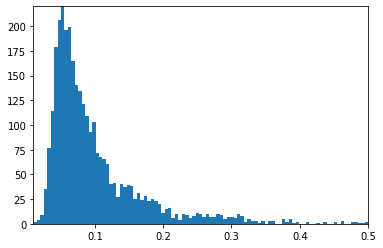

In [89]:
_ = plt.hist( nf_targets[10], bins=np.linspace(0,0.5,100))
plt.xlim([0.01,0.5])
plt.ylim([0,220])

(0, 220)

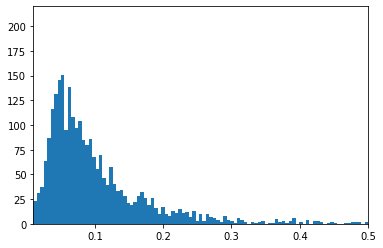

In [90]:
_ = plt.hist(preds[10], bins=np.linspace(0,0.5,100) )
plt.xlim([0.01,0.5])
plt.ylim([0,220])

#### Save data for visualization

In [91]:
L_nodes, Q_edges

(array(['(55, 386)', '(112, 2416)', '(0, 136)', ..., '(943, 1003)',
        '(436, 475)', '(2102, 2206)'], dtype='<U12'),
 array(['(0, 2)', '(0, 3)', '(0, 4)', ..., '(3163, 3165)', '(3252, 3312)',
        '(3302, 3390)'], dtype='<U12'))

In [92]:
L_nodes_to_weights = dict( zip( L_nodes, preds[10].flatten() ) )
#L_nodes_to_weights

In [93]:
Q_edge_features_pred = np.array( [ L_nodes_to_weights[ q ] for q in Q_edges ] )
Q_edge_features_pred.shape

(3150,)

In [94]:
np.save( source+'../'+'GraphNN_linegraph_edge_prediction_test', Q_edge_features_pred )

### Visualization is in the data prep notebook!